In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [6]:
# the classes that automap found
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
columns = inspector.get_columns("measurement")

print("'measurement'")
for c in columns:
    print(c["name"], c["type"])
columns = inspector.get_columns("station")
pprint(engine.execute('SELECT * FROM measurement limit 5').fetchall())

print("\n'station'")
for c in columns:
    print(c["name"], c["type"])
pprint(engine.execute('SELECT * FROM station limit 5').fetchall())

'measurement'
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

'station'
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).first()

('2010-01-01',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latestDay = session.query(func.max(measurement.date)).scalar()
latestDay

'2017-08-23'

In SQLAlchemy, the `scalar()` method is used to execute a query and return the first column of the first row of the query result as a scalar value (i.e., a single value, not a row or a list). 

Using `scalar()` is convenient when you expect the query to return only a single value, and it avoids the need to extract the value from a row or a list. 

If the query could potentially return multiple rows or no rows, you should use other methods like all(), first(), or one() to handle the results appropriately.

In [11]:
oneYearAgo = dt.strptime(latestDay, "%Y-%m-%d") - timedelta(days=365)
#oneYearAgo.strftime("%Y-%m-%d")
oneYearAgo

datetime.datetime(2016, 8, 23, 0, 0)

In [12]:
#session.query(measurement.date, measurement.prcp).filter(measurement.date>=oneYearAgo, measurement.date<=latestDay).all()

In [13]:
prcpData = pd.DataFrame(session.query(measurement.date, measurement.prcp).filter(measurement.date>=oneYearAgo, measurement.date<=latestDay).all())
prcpData

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [14]:
step = 100
ticks = range(0, len(prcpData), step)
ticks

range(0, 2223, 100)

In [15]:
prcpData["date"].iloc[ticks]

0       2016-08-24
100     2016-12-02
200     2017-03-12
300     2017-06-22
400     2016-10-03
500     2017-01-11
600     2017-04-21
700     2017-07-30
800     2016-12-20
900     2017-04-20
1000    2017-08-17
1100    2017-02-06
1200    2016-09-06
1300    2016-12-17
1400    2017-04-11
1500    2017-07-27
1600    2016-11-08
1700    2017-02-16
1800    2017-05-27
1900    2016-09-19
2000    2016-12-31
2100    2017-04-16
2200    2017-07-31
Name: date, dtype: object

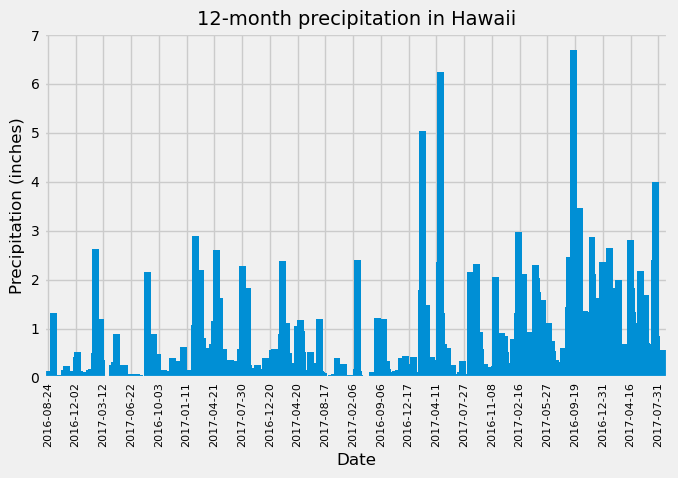

In [51]:
prcpPlot = prcpData.plot(kind="bar", width=25, figsize=(7,5))
prcpPlot.set_xticks(ticks)
prcpPlot.set_xticklabels(prcpData["date"].iloc[ticks], rotation=90, size=8)
prcpPlot.tick_params(axis='y', labelsize=10)
prcpPlot.set_xlabel("Date", fontsize=12)
prcpPlot.set_ylabel("Precipitation (inches)", fontsize=12)
prcpPlot.set_title("12-month precipitation in Hawaii", fontsize=14)
prcpPlot.legend().set_visible(False)
plt.tight_layout()
plt.savefig("images/12monthPrcp.png")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainSummary = pd.DataFrame(prcpData["prcp"].describe())
rainSummary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
print("'station'")
for c in columns:
    print(c["name"], c["type"])
pprint(engine.execute('SELECT * FROM station limit 5').fetchall())

'station'
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]


In [19]:
# calculate the total number of stations in the dataset
session.query(func.count(station.station)).scalar()

9

In [20]:
pd.DataFrame(session.query(measurement.station, station.name).all())

/var/folders/nq/4fdxpg5x3813lq3gth8vk6sc0000gn/T/ipykernel_59154/214359586.py:1: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  pd.DataFrame(session.query(measurement.station, station.name).all())


,station,name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00519397,"KANEOHE 838.1, HI US"
2,USC00519397,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00519397,"PEARL CITY, HI US"
4,USC00519397,"UPPER WAHIAWA 874.3, HI US"
...,...,...
175945,USC00516128,"UPPER WAHIAWA 874.3, HI US"
175946,USC00516128,"WAIMANALO EXPERIMENTAL FARM, HI US"
175947,USC00516128,"WAIHEE 837.5, HI US"
175948,USC00516128,"HONOLULU OBSERVATORY 702.2, HI US"


In [21]:
stationAcitvity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
stationAcitvity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
stationAcitvityCount = pd.DataFrame(stationAcitvity, columns=["station", "activities"]) #it doesn't register func.count() so it does not have a name, make it being recognized as one column. have to sepcify column names (and thus count)
stationAcitvityCount

,station,activities
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [25]:
topStationTemp = pd.DataFrame(session.query(measurement.date, measurement.tobs).filter(measurement.station == "USC00519281").filter(measurement.date>=oneYearAgo, measurement.date<=latestDay).all())
print(topStationTemp.dtypes)
topStationTemp

date     object
tobs    float64
dtype: object


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


In [26]:
topStationTempFq = topStationTemp.groupby("tobs").count()
topStationTempFq.tail(7)

,date
tobs,
77.0,30
78.0,22
79.0,18
80.0,11
81.0,4
82.0,3
83.0,1


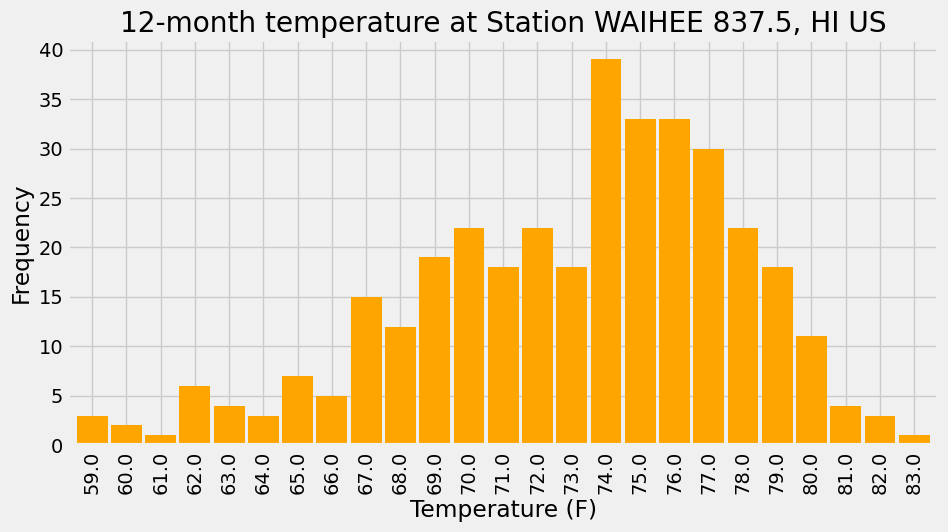

In [27]:
topStationTempFqPlot = topStationTempFq.plot(kind="bar", width=0.9, xlabel="Temperature (F)", ylabel="Frequency", color="orange", figsize=(10,5), title="12-month temperature at Station WAIHEE 837.5, HI US")
topStationTempFqPlot.legend().set_visible(False)

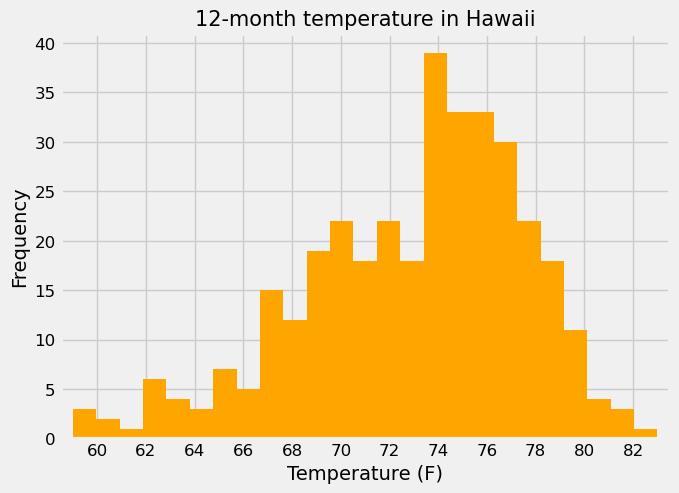

In [58]:
topStationTempPlot = topStationTemp.plot(kind="hist", bins=25, figsize=(7,5), color="orange")
topStationTempPlot.locator_params(axis='x', nbins=15)
topStationTempPlot.legend().set_visible(False)
topStationTempPlot.set_xlabel("Temperature (F)", size=14)
topStationTempPlot.set_ylabel("Frequency", size=14)
topStationTempPlot.set_xlim(58.5,83.5)
topStationTempPlot.set_title("12-month temperature in Hawaii", size=15)
topStationTempPlot.tick_params(axis='both', labelsize=12)


# Close Session

In [16]:
# Close Session
session.close()